## SerieTemporal 4 Covid 19 - Elaborada

In [1]:
!pip install mplfinance
!pip install chart_studio

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 71kB 3.6MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json
from pandas import DataFrame as df

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Pequeña introducción desde donde se pueden sacar datos desde la URL

web Scraping Data, resumido, no quiero solaparme con otra asignatura

In [ ]:
# Recogemos de la URL
web_page = requests.get("https://www.worldometers.info/coronavirus")
soup = BeautifulSoup(web_page.text, 'html.parser')
print(soup.prettify()) # Get source from site

### Basic Covid Data

In [5]:
# Find basic data in div with class name maincounter-number
covid_data = soup.find_all("div",class_ = "maincounter-number")
# 
print("Coronavirus Cases: ", covid_data[0].text.strip())
print("Deaths: ", covid_data[1].text.strip())
print("Recovered: ", covid_data[2].text.strip())

# If I wanted world data I could search for script tags with type
# set as text/javascript
data = soup.find_all("script", {"type":"text/javascript"})
# for content in data:
#     print(content)

Coronavirus Cases:  113,796,237
Deaths:  2,524,103
Recovered:  89,384,542


In [6]:
# Search for table with id main_table_countries_today
results = soup.find(id='main_table_countries_today')
# Print all tds
content = results.find_all('td')
# content

In [7]:
clean_data = ""
# Use a different separator since the commas cause confusion
for data in content:
    clean_data += data.text.strip() + "|"
# Get rid of pluses
clean_data = clean_data.replace("+", "")
# Get rid of N/A
clean_data = clean_data.replace("N/A", "0")
# clean_data

### Cleaning Up with Regex

In [ ]:
import re

# Got a list of countries from the website
countries = [
    'usa', 'spain', 'italy', 'france', 'germany', 'uk', 'turkey', 'iran', 
    'russia', 'brazil', 'canada', 'belgium', 'netherlands', 'switzerland', 
    'india', 'peru', 'portugal', 'ecuador', 'ireland', 'sweden', 'saudi-arabia', 
    'israel', 'austria', 'mexico', 'singapore', 'japan', 'chile', 'pakistan', 
    'poland', 'romania', 'belarus', 'qatar', 'south-korea', 'united-arab-emirates', 
    'indonesia', 'ukraine', 'denmark', 'serbia', 'philippines', 'norway', 
    'czech-republic', 'australia', 'dominican-republic', 'bangladesh', 'malaysia', 
    'panama', 'colombia', 'finland', 'south-africa', 'egypt', 'morocco', 'argentina', 
    'luxembourg', 'moldova', 'algeria', 'kuwait', 'thailand', 'kazakhstan', 
    'bahrain', 'hungary', 'greece', 'oman', 'croatia', 'uzbekistan', 'iraq', 
    'armenia', 'iceland', 'afghanistan', 'estonia', 'azerbaijan', 'cameroon', 
    'bosnia-and-herzegovina', 'ghana', 'new-zealand', 'lithuania', 'slovenia', 
    'macedonia', 'slovakia', 'cuba', 'bulgaria', 'nigeria', 'cote-d-ivoire', 
    'china-hong-kong-sar', 'djibouti', 'guinea', 'bolivia', 'tunisia', 'latvia', 
    'cyprus', 'andorra', 'albania', 'lebanon', 'niger', 'kyrgyzstan', 'costa-rica', 
    'senegal', 'honduras', 'burkina-faso', 'uruguay', 'sri-lanka', 'san-marino', 
    'channel-islands', 'guatemala', 'georgia', 'democratic-republic-of-the-congo', 
    'malta', 'jordan', 'somalia', 'taiwan', 'reunion', 'mayotte', 'mali', 'kenya', 
    'jamaica', 'state-of-palestine', 'mauritius', 'venezuela', 'el-salvador', 
    'montenegro', 'isle-of-man', 'tanzania', 'viet-nam', 'equatorial-guinea', 
    'sudan', 'paraguay', 'maldives', 'congo', 'rwanda', 'faeroe-islands', 'gabon', 
    'martinique', 'guadeloupe', 'myanmar', 'gibraltar', 'brunei-darussalam', 
    'liberia', 'ethiopia', 'madagascar', 'cambodia', 'trinidad-and-tobago', 
    'french-guiana', 'bermuda', 'cabo-verde', 'aruba', 'togo', 'monaco', 
    'sierra-leone', 'zambia', 'liechtenstein', 'bahamas', 'barbados', 'uganda', 
    'mozambique', 'sint-maarten', 'guyana', 'haiti', 'cayman-islands', 'benin', 
    'libya', 'swaziland', 'french-polynesia', 'guinea-bissau', 'nepal', 'chad', 
    'china-macao-sar', 'syria', 'eritrea', 'saint-martin', 'mongolia', 'malawi', 
    'zimbabwe', 'angola', 'antigua-and-barbuda', 'timor-leste', 'botswana', 
    'central-african-republic', 'laos', 'belize', 'fiji', 'grenada', 'new-caledonia', 
    'curacao', 'dominica', 'namibia', 'saint-kitts-and-nevis', 'saint-lucia', 
    'saint-vincent-and-the-grenadines', 'nicaragua', 'falkland-islands-malvinas', 
    'burundi', 'montserrat', 'turks-and-caicos-islands', 'greenland', 'seychelles', 
    'gambia', 'suriname', 'holy-see', 'papua-new-guinea', 'mauritania', 'bhutan', 
    'british-virgin-islands', 'saint-barthelemy', 'south-sudan', 'western-sahara', 
    'caribbean-netherlands', 'sao-tome-and-principe', 'anguilla', 'saint-pierre-and-miquelon', 
    'yemen', 'china'
]

# Cycle through countries
for c in countries:
    # Add country name plus look for all , | and any numbers that follow
    pattern = c+"[,|\d]*"
    # Search for the pattern and ignore case so I don't have to worry about
    # country capitalization
    data = re.search(pattern, clean_data, re.IGNORECASE)
    # If data is a NoneType ignore it
    if data is not None:
         print(data.group())


### Working with CSV Data

Los recogemos de la web: https://ourworldindata.org/

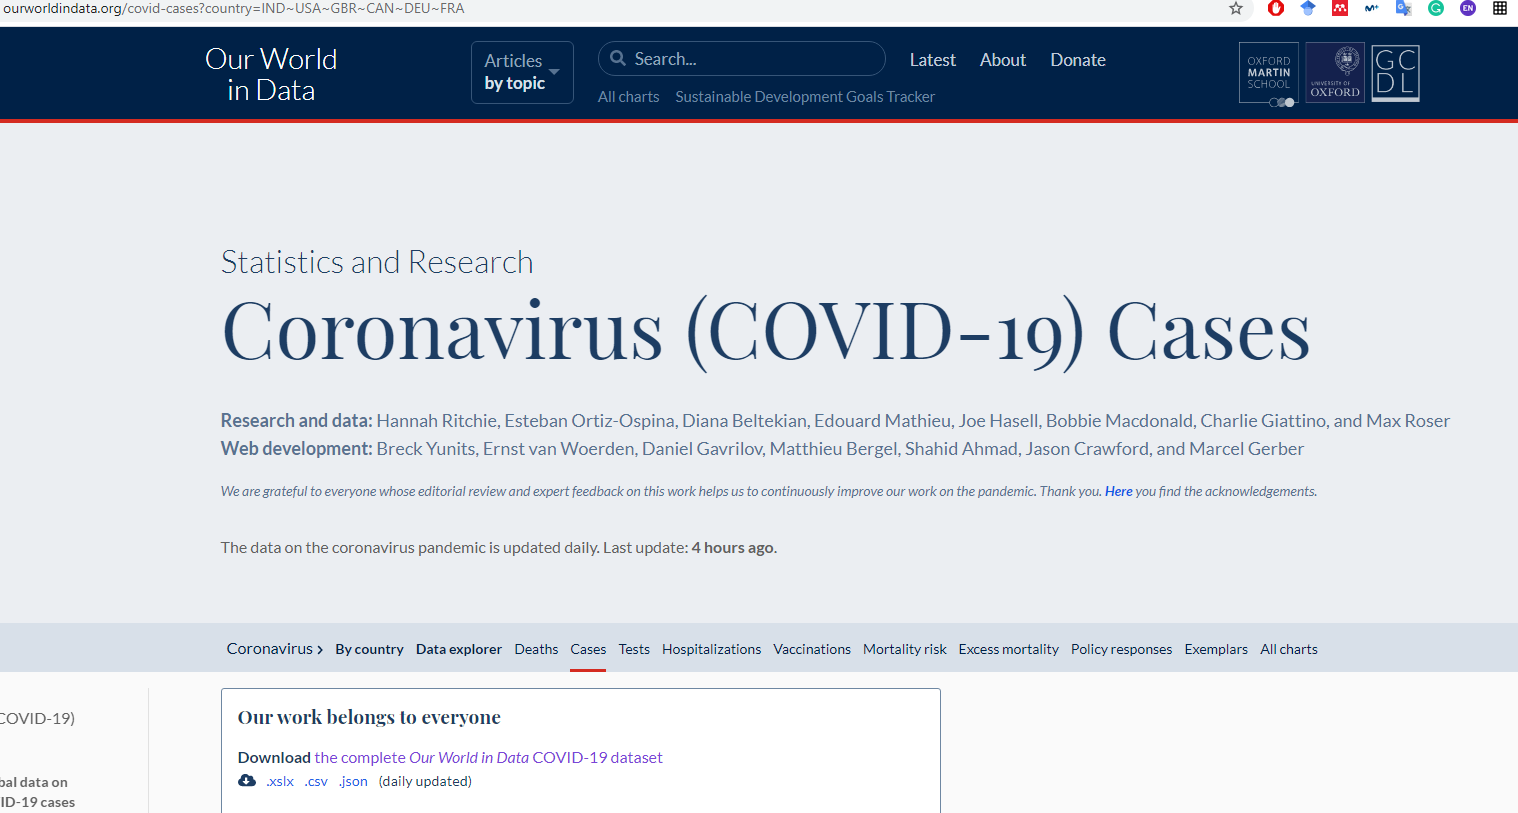

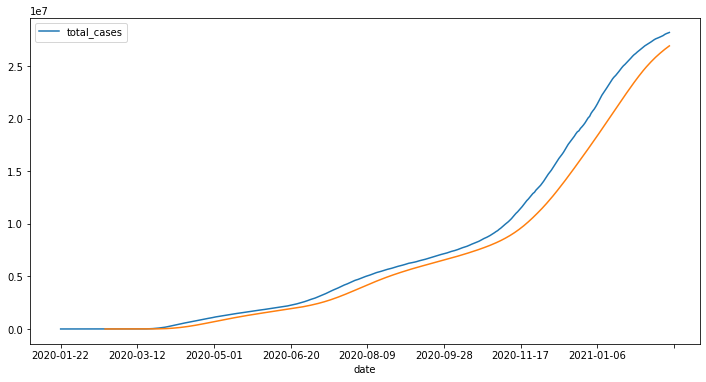

In [19]:

owid_df = pd.read_csv('owid-covid-data.csv')

owid_df.columns # Show all columns

# Create Numpy array of unique countries
country_df = owid_df.location.unique()
country_df # Show countries
country_df.size # How many countries (214)

# Get indexes for location rows equal to United States
indexer = owid_df[owid_df['location']=='United States'].index
# Get dataframe location and total cases for United States
us_tc = owid_df.loc[indexer, 'date':'total_cases']
# Delete NaN values
us_tc = us_tc.dropna()
# Set date as index
us_tc.set_index('date', inplace=True)
us_tc.plot(figsize=(12,6))

# Plot a 30 day moving average, línea naranja, podemos variar la ventana de 30
us_tc.rolling(window=30).mean()['total_cases'].plot()

# owid_df.columns
# country_df

Vamos a ver algunas correlaciones entre los datos de forma gráfica y mediante el tiempo, series temporales

### ¿Funcionan los confinamientos?

In [ ]:
owid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


Index(['new_cases_per_million'], dtype='object')
Index(['new_cases_per_million'], dtype='object')


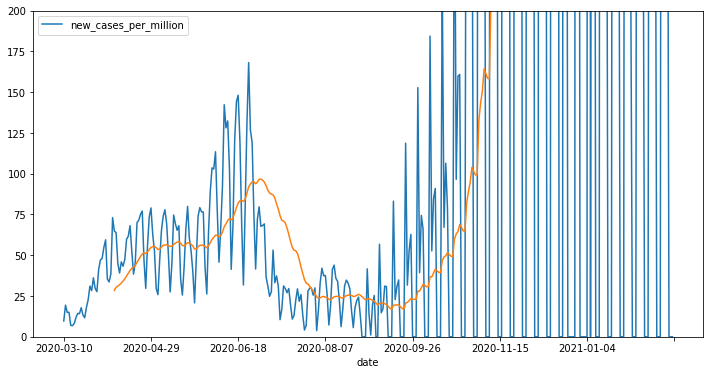

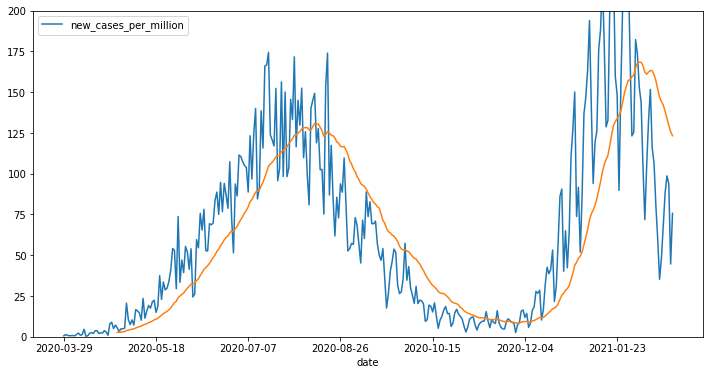

In [24]:
def plot_covid_data(country, col, plot_ma=False, y_max=200):
    # Get indexes for location rows equal to country name
    indexer = owid_df[owid_df['location']==country].index
    # Get dataframe location and column data for country name
    country_df = owid_df.loc[indexer, 'date':col]
    # Delete NaN values
    country_df = country_df.dropna()
    # Set date as index
    country_df.set_index('date', inplace=True)
    # Remove all columns except for what I want
    country_df.drop(country_df.columns.difference([col]), 1, inplace=True)
    country_df.plot(figsize=(12,6), ylim=[0,y_max])

    # Plot moving average if requested
    if plot_ma:
        # Plot a 30 day moving average, recordad 30 para que salga tendencia y suavizado, otherwise 5, 10
        country_df.rolling(window=30).mean()[col].plot()
    print(country_df.columns)
    
# Least restrictive lockdown
plot_covid_data('Sweden', 'new_cases_per_million', True)
# Most restrictive lockdown measures
plot_covid_data('Bolivia', 'new_cases_per_million', True) 

# owid_df.columns

### How Does Median Age Effect Death Rate?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


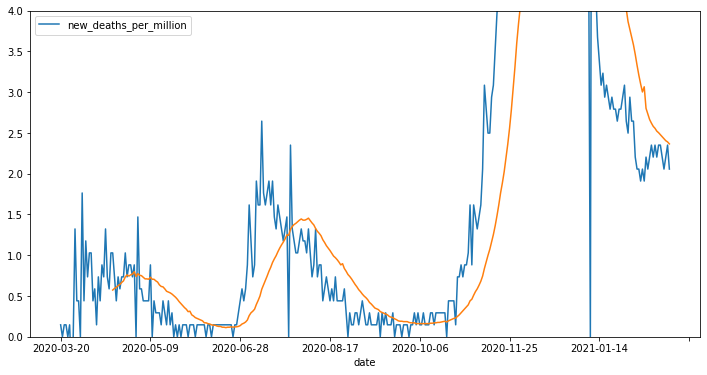

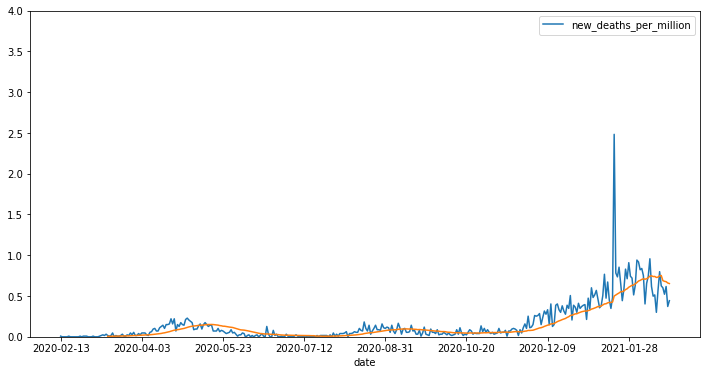

In [42]:
# Country with lowest median age
plot_covid_data('Serbia', 'new_deaths_per_million', True, 4)   # con 2.5 puede observarlo mejor, sino apenas se ve
# Country with highest median age
plot_covid_data('Japan', 'new_deaths_per_million', True, 4)

### How Does Obesity Effect Death Rate?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


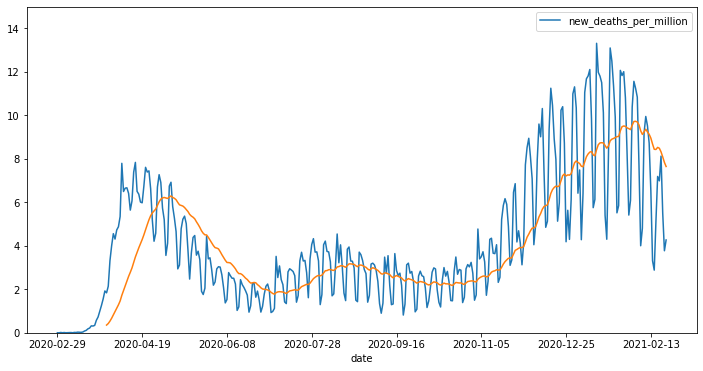

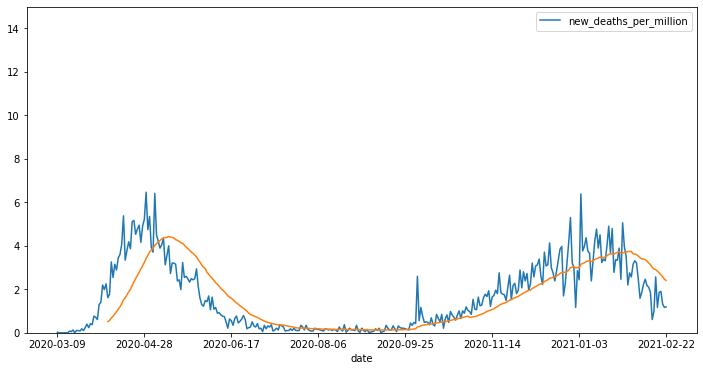

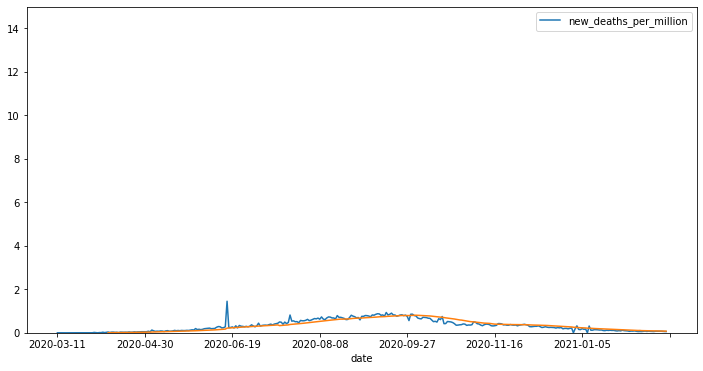

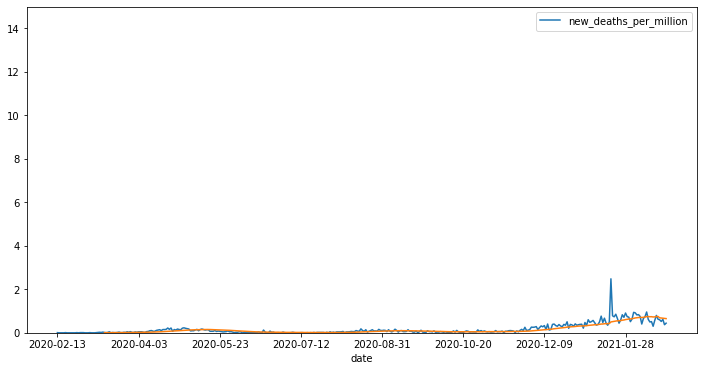

In [39]:
# Countries with highest percentages 
plot_covid_data('United States', 'new_deaths_per_million', True, 15)
plot_covid_data('Canada', 'new_deaths_per_million', True, 15)
# 2 countries with lowest percentages
plot_covid_data('India', 'new_deaths_per_million', True, 15)
plot_covid_data('Japan', 'new_deaths_per_million', True, 15)

### How Does Diabetes Prevalence Effect Death?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


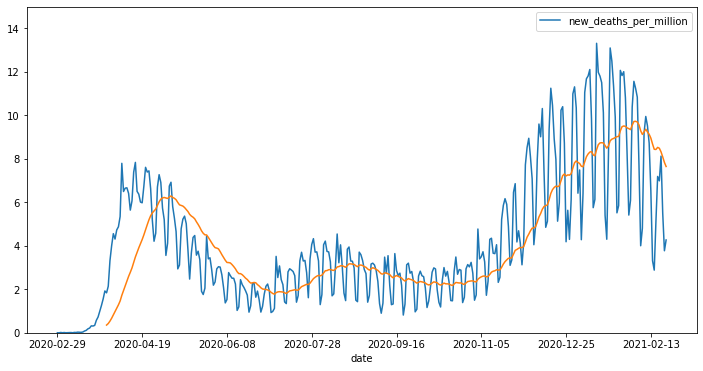

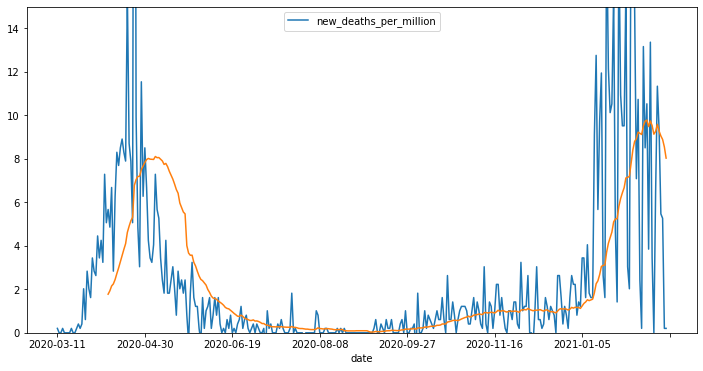

In [46]:
# Country with highest percentage 
plot_covid_data('United States', 'new_deaths_per_million', True, 15)
# Country with lowest percentage
plot_covid_data('Ireland', 'new_deaths_per_million', True, 15)

### Does More Testing Slow Deathrate?

Index(['new_deaths_per_million'], dtype='object')
Index(['new_deaths_per_million'], dtype='object')


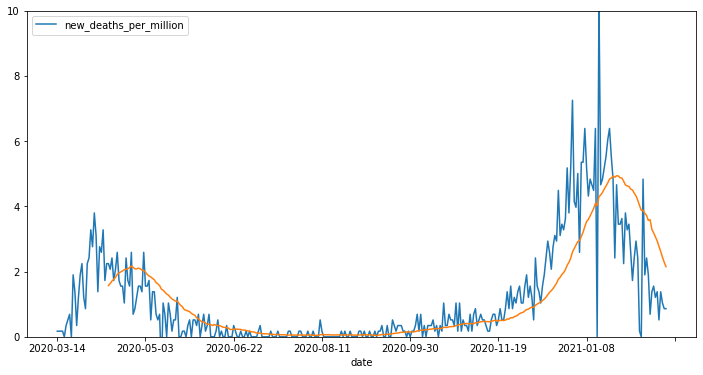

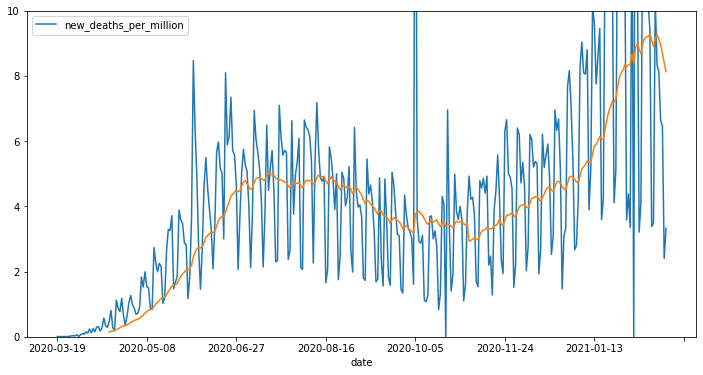

In [47]:
# Country with highest percentage 
plot_covid_data('Denmark', 'new_deaths_per_million', True, 10)
# Country with lowest percentage
plot_covid_data('Mexico', 'new_deaths_per_million', True, 10)

In [44]:
# Receives date and column of interest for every country as a dataframe
def scatter_plot(date, col1, col2):
    tot_df = pd.DataFrame(columns = ['date', 'location', col1, col2])
    # temp_df = pd.DataFrame()
    for c in country_df:
        # Get country specific data and append to main dataframe
        temp_df = owid_df[(owid_df['location']==c) & (owid_df['date']==date)][['date', 'location', col1, col2]]
        tot_df = tot_df.append(temp_df, ignore_index = True).fillna(0)
    tot_df.set_index('date', inplace=True)
    
    # Create Plotly scatter plot
    fig = px.scatter(data_frame=tot_df, x=col2, 
                     y=col1, color="location", trendline="ols",
                 hover_data=['location'])
    fig.show()
    
    return tot_df



 




In [45]:
# Try median_age, aged_70_older, diabetes_prevalence, male_smokers, 
scatter_plot('2020-10-27', 'total_deaths_per_million', 'aged_70_older')

,location,total_deaths_per_million,aged_70_older
date,,,
2020-10-27,Afghanistan,39.175,1.337
2020-10-27,Africa,31.172,0.000
2020-10-27,Albania,169.226,8.643
2020-10-27,Algeria,44.035,3.857
2020-10-27,Andorra,931.858,0.000
...,...,...,...
2020-10-27,Vietnam,0.360,4.718
2020-10-27,World,149.961,5.355
2020-10-27,Yemen,20.083,1.583
